In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Pytorch Imagefolder for loading data

In [ ]:
dataset_path = '/content/drive/MyDrive/PRML Project/covid 19/Extensive COVID-19 X-Ray and CT Chest Images Dataset.zip (Unzipped Files)/COVID-19 Dataset.zip (Unzipped Files)/COVID-19 Dataset/X-ray'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import os
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
from torchvision.transforms.transforms import RandomHorizontalFlip
dataset_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])

In [ ]:
dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform = dataset_transforms)

In [ ]:
dataset[0][0].shape

torch.Size([3, 224, 224])

In [ ]:
torchvision.transforms.Grayscale()(dataset[0][0]).shape

torch.Size([1, 224, 224])

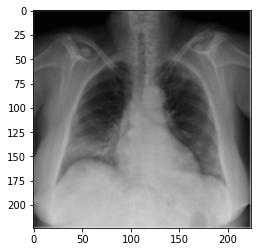

In [ ]:
plt.imshow(dataset[0][0].permute(1, 2, 0), interpolation='bicubic')

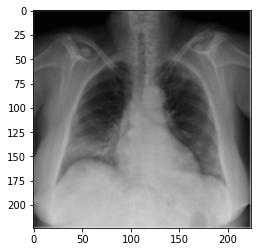

In [ ]:
plt.imshow(transforms.ToPILImage()(dataset[0][0]), interpolation="bicubic")

In [ ]:
len(dataset)

9537

In [ ]:
train_size = int(0.7 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,validation_size])

In [ ]:
def split_XY(dataset):
    l = []
    a = torch.Tensor(len(dataset), 1, 224, 224)
    for i, (image, label) in enumerate(dataset):
        # a[i, :, :, :] = image
        a[i, :, :, :] = torchvision.transforms.Grayscale()(image)
        l.append(label)
    return a, torch.Tensor(l)

In [ ]:
X, Y = split_XY(dataset)

In [ ]:
X_train, y_train = split_XY(train_dataset)

In [ ]:
X_test, y_test = split_XY(test_dataset)

In [ ]:
cuda = torch.device('cuda')

In [ ]:
X_train.shape, y_train.shape

(torch.Size([6675, 1, 224, 224]), torch.Size([6675]))

In [ ]:
X_test.shape, y_test.shape

(torch.Size([2862, 1, 224, 224]), torch.Size([2862]))

In [ ]:
X = X.to(cuda)
Y1 = Y.to(cuda)
X1 = torch.reshape(X, (X.shape[0], X.shape[2] * X.shape[3]))

In [ ]:
X1.shape

torch.Size([9537, 50176])

In [ ]:
X_train = torch.Tensor(X_train).to(cuda)
X_test = torch.Tensor(X_test).to(cuda)

In [ ]:
X_train.shape[2], X_test.shape[2]

(224, 224)

In [ ]:
X_train1 = torch.reshape(X_train, (X_train.shape[0], X_train.shape[2]*X_train.shape[3]))
X_test1 = torch.reshape(X_test, (X_test.shape[0], X_test.shape[2]*X_test.shape[3]))

In [ ]:
X_train1.shape, X_test1.shape

(torch.Size([6675, 50176]), torch.Size([2862, 50176]))

In [ ]:
y_train1 = y_train.to(cuda)
y_test1 = y_test.to(cuda)

In [ ]:
X_train_np = X_train1.cpu().detach().numpy()
y_train_np = y_train1.cpu().detach().numpy()
X_test_np = X_test1.cpu().detach().numpy()
y_test_np = y_test1.cpu().detach().numpy()

RFC

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier().fit(X_train_np, y_train_np)
y_pred = clf.predict(X_test_np)
y_pred_proba = clf.predict_proba(X_test_np)
print(classification_report(y_test_np, y_pred))

              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      1248
         1.0       0.86      0.89      0.88      1614

    accuracy                           0.86      2862
   macro avg       0.86      0.86      0.86      2862
weighted avg       0.86      0.86      0.86      2862



ValueError: ignored

In [ ]:
print(roc_auc_score(y_test_np, y_pred))

0.8550602897721856


[Text(0.5, 1.0, 'CM for RFC')]

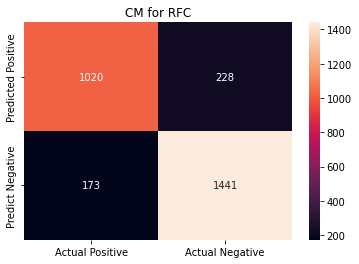

In [ ]:
cm_matrix1 = pd.DataFrame(data = confusion_matrix(pd.Series(y_test_np, dtype=int), pd.Series(y_pred)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix1, annot=True, fmt='d').set(title='CM for RFC')

Evaluation metrics:

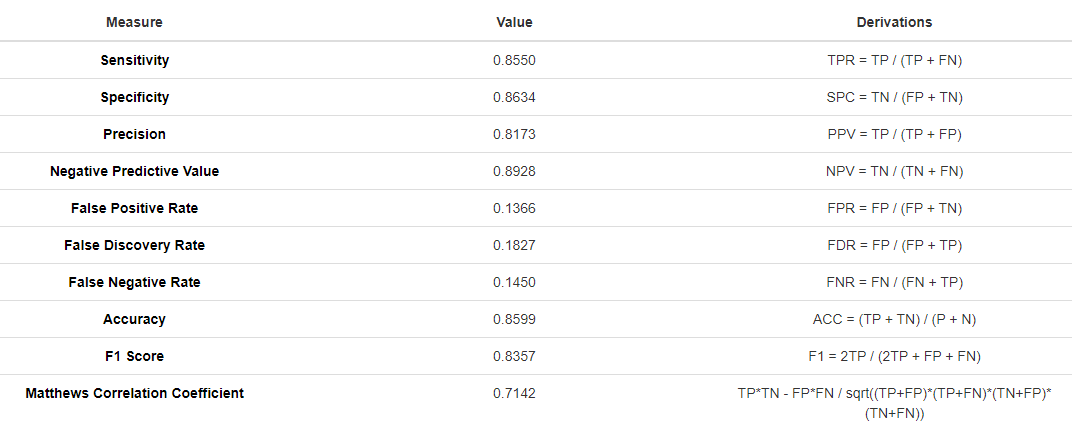

XGB after doing PCA

PCA sklearn 

In [ ]:
X1_np = X1.cpu().detach().numpy()
Y1_np = Y1.cpu().detach().numpy()

In [ ]:
X1_np.shape, Y1_np.shape

((9537, 50176), (9537,))

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.80 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present
pca = PCA(variance)

In [ ]:
pca_np_sk=pca.fit_transform(X1_np)

In [ ]:
pca.n_components_

NameError: ignored

In [ ]:
pca_np_sk = pd.DataFrame(pca_np_sk)

In [ ]:
print("Number of components before PCA  = " + str(X1_np.shape[1]))
print("Number of components after PCA 0.80 = " + str(pca.n_components_))

In [ ]:
loaded_values = pca.explained_variance_ratio_

In [ ]:
percent = loaded_values/sum(loaded_values)

In [ ]:
plt.bar([i for i in range(1,714)], percent)
plt.xlabel('Number of Prinical Components')
plt.ylabel('Variance Conserved')
plt.show()

In [ ]:
pca_np_sk

In [ ]:
from sklearn.model_selection import train_test_split as tts
X_train_pca, X_test_pca, y_train_pca, y_test_pca = tts(pca_np_sk, Y1_np, train_size = 0.7)

xgb

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score,roc_auc_score
# fit model no training data
model_xg = XGBClassifier().fit(X_train_pca, y_train_pca)
y_pred = model_xg.predict(X_test_pca)
y_pred_proba = model_xg.predict_proba(X_test_pca)
print(accuracy_score(y_test_pca, y_pred))
print(classification_report(y_test_pca, y_pred))
print('ROC-AUC:',roc_auc_score(y_test_pca, y_pred_proba))

In [ ]:
cm_matrix2 = pd.DataFrame(data = confusion_matrix(pd.Series(y_test_np, dtype=int), pd.Series(y_pred)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix2, annot=True, fmt='d').set(title='CM for ')

LGB on PCA

In [ ]:
!pip install lightgbm
import lightgbm as lgb

In [ ]:
lgb_clf = lgb.LGBMClassifier().fit(X_train_pca, y_train_pca)
y_pred = lgb_clf.predict(X_test_pca)
y_pred_proba = lgb_clf.predict_proba(X_test_pca)
print(accuracy_score(y_test_pca, y_pred))
print(classification_report(y_test_pca, y_pred))
print("ROC-AUC:", roc_auc_score(y_test_pca, y_pred_proba))

In [ ]:
cm_matrix3 = pd.DataFrame(data = confusion_matrix(pd.Series(y_test_np, dtype=int), pd.Series(y_pred)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix2, annot=True, fmt='d').set(title='CM for ')

# PCA of pytorch

In [ ]:
m = X1.mean(0, keepdim=True)
s = X1.std(0, unbiased=False, keepdim=True)
X1 -= m
X1 /= s

In [ ]:
X1.shape

In [ ]:
U, S, V = torch.pca_lowrank(X1, q=min(X1.shape[0], X1.shape[1]), center = True, niter = 100)

In [ ]:
S.shape

In [ ]:
eigenvalues = S

In [ ]:
eigenval = eigenvalues.cpu().detach().numpy()

In [ ]:
loaded_vals = eigenval/eigenval.sum() 

In [ ]:
loaded_vals[:2114].sum()

In [ ]:
np.array([i for i in range(1,2115)]).shape

In [ ]:
loaded_vals.shape

In [ ]:
plt.bar([i for i in range(1,2115)], loaded_vals[:2114])

In [ ]:
S

In [ ]:
eigenvectors = V

In [ ]:
indexsort = torch.argsort(S, descending=True)

In [ ]:
indexsort

In [ ]:
sorteigenvalue = eigenvalues[indexsort]

In [ ]:
sorteigenvectors = eigenvectors[:, indexsort]

In [ ]:
sorteigenvectors.shape

In [ ]:
X1.shape

In [ ]:
eigenvectorsubset = sorteigenvectors[:, :2114]

In [ ]:
eigenvectorsubset.shape

In [ ]:
pca_x = torch.matmul(X1, eigenvectorsubset)

In [ ]:
pd.DataFrame(pca_x.cpu().detach().numpy())

In [ ]:
pca_x.shape

## Kmeans sklearn on PCA pytorch

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
pca_x_np = pca_x.cpu().detach().numpy()

In [ ]:
pca_x_np.shape

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(pca_x_np)

In [ ]:
y_pred_np = kmeans.labels_

In [ ]:
y_pred_np

In [ ]:
y_true = y.cpu().detach().numpy()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm_matrix2 = pd.DataFrame(data = confusion_matrix(pd.Series(y_true, dtype=int), pd.Series(y_pred_np)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix2, annot=True, fmt='d').set(title='CM for Kmeans')

Evaluation Metrics on preserving 98% variance:

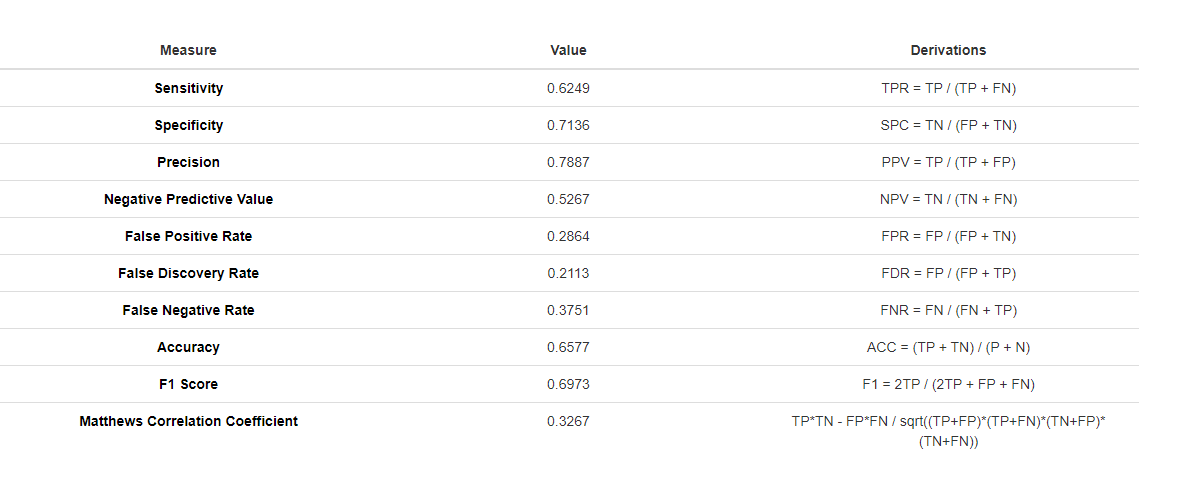

In [ ]:
y_true

In [ ]:
y_pred_np

In [ ]:
np.unique(y_pred_np, return_counts=True)

In [ ]:
np.unique(y_true, return_counts=True)

# PCA sklearn 

In [ ]:
X1_np = X1.cpu().detach().numpy()

In [ ]:
X1_np.shape

In [ ]:
from sklearn.decomposition import PCA
# Make an instance of the Model
variance = 0.98 #The higher the explained variance the more accurate the model will remain, but more dimensions will be present
pca = PCA(variance)

In [ ]:
pca_np_sk=pd.DataFrame(pca.fit_transform(X1_np))

In [ ]:
print("Number of components before PCA  = " + str(X1_np.shape[1]))
print("Number of components after PCA 0.98 = " + str(pca.n_components_))

In [ ]:
loaded_values = pca.explained_variance_ratio_

In [ ]:
percent = loaded_values/sum(loaded_values)

In [ ]:
plt.bar([i for i in range(1,714)], percent)
plt.xlabel('Number of Prinical Components')
plt.ylabel('Variance Conserved')
plt.show()

In [ ]:
pca_np_sk

## Kmeans Sklearn

In [ ]:
kmeans2 = KMeans(n_clusters=2, random_state=0).fit(pca_np_sk)

In [ ]:
y_pred_np_sk = kmeans2.labels_

In [ ]:
cm_matrix2 = pd.DataFrame(data = confusion_matrix(pd.Series(y_true, dtype=int), pd.Series(y_pred_np_sk)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix2, annot=True, fmt='d').set(title='CM for Agglomerative Clustering')

# Sklearn Agglomerative Clustering on pca_x_np (dimensionally reduced dataframe of pca_lowrank())

In [ ]:
from sklearn.cluster import AgglomerativeClustering as AC
aggcluster1=AC(n_clusters=2).fit_predict(pca_x_np)

In [ ]:
pca_x_np.shape

In [ ]:
cm_matrix3 = pd.DataFrame(data = confusion_matrix(pd.Series(y_true, dtype=int), pd.Series(aggcluster1)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix3, annot=True, fmt='d').set(title='CM for Agglomerative Clustering')

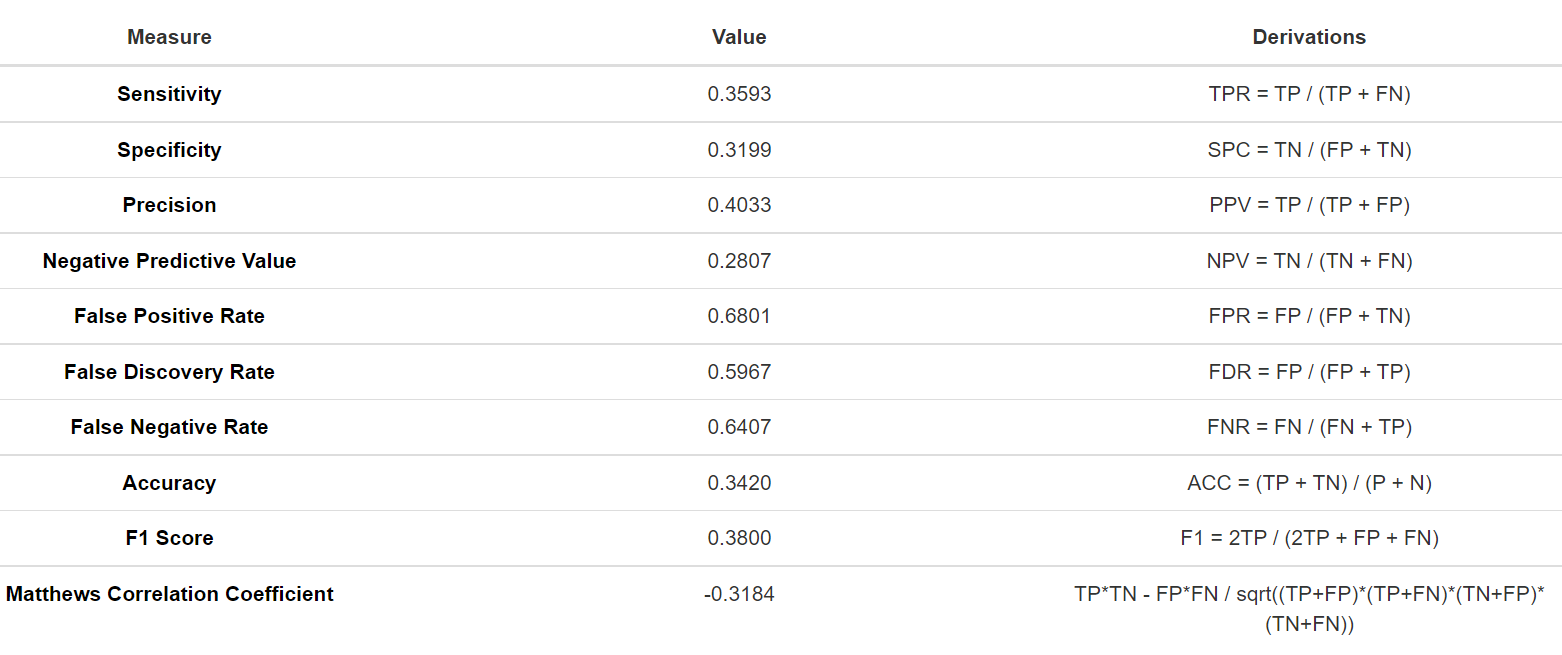

# Sklearn Agglomerative Clustering on pca_np_sk (dimensionally reduced dataframe of PCA())

In [ ]:
from sklearn.cluster import AgglomerativeClustering as AC
aggcluster2=AC(n_clusters=2).fit_predict(pca_np_sk)

In [ ]:
pca_np_sk.shape

In [ ]:
cm_matrix3 = pd.DataFrame(data = confusion_matrix(pd.Series(y_true, dtype=int), pd.Series(aggcluster2)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix3, annot=True, fmt='d').set(title='CM for Agglomerative Clustering')

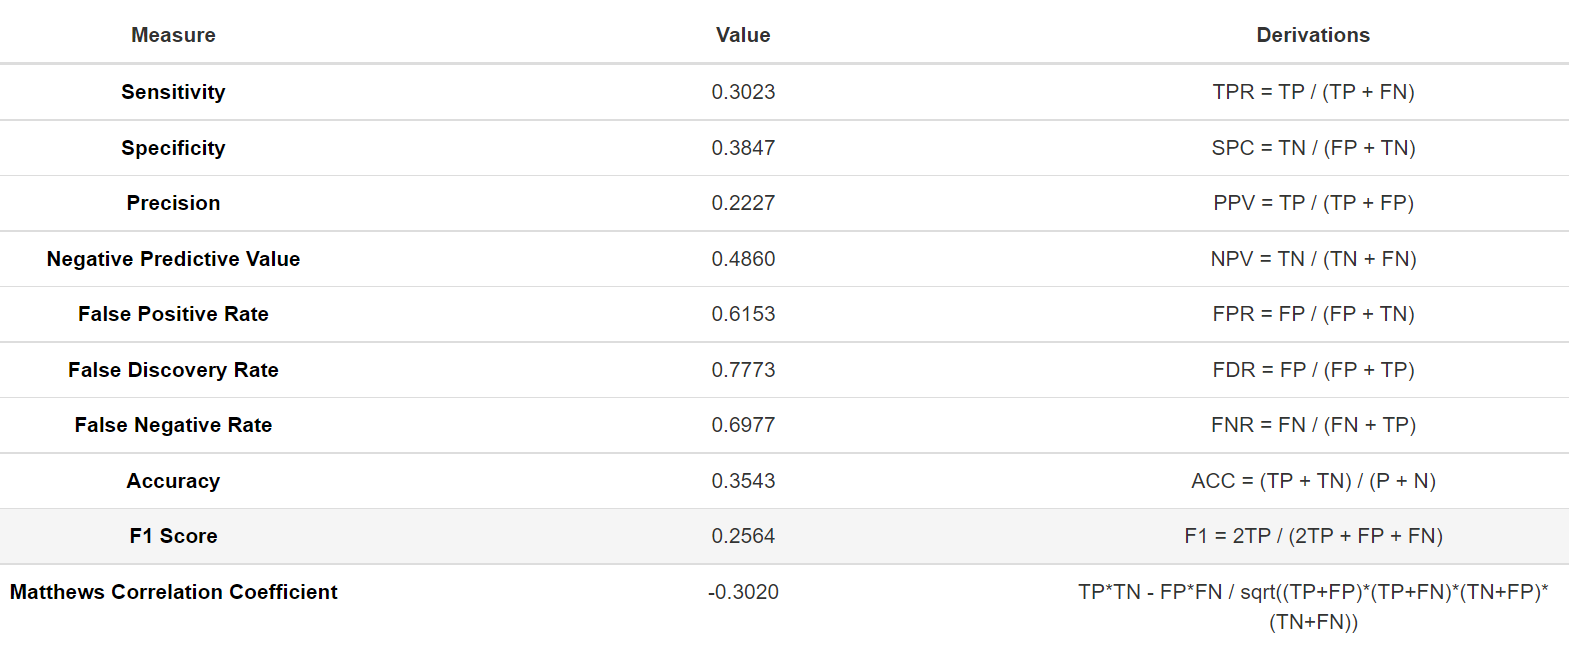

# Sklearn Agglomerative Clustering on X1_np (full dataframe)

In [ ]:
from sklearn.cluster import AgglomerativeClustering as AC
aggcluster3=AC(n_clusters=2).fit_predict(X1_np)

In [ ]:
X1_np.shape

In [ ]:
cm_matrix3 = pd.DataFrame(data = confusion_matrix(pd.Series(y_true, dtype=int), pd.Series(aggcluster3)), columns = ['Actual Positive', 'Actual Negative'], index = ['Predicted Positive', 'Predict Negative'])
sns.heatmap(cm_matrix3, annot=True, fmt='d').set(title='CM for Agglomerative Clustering')

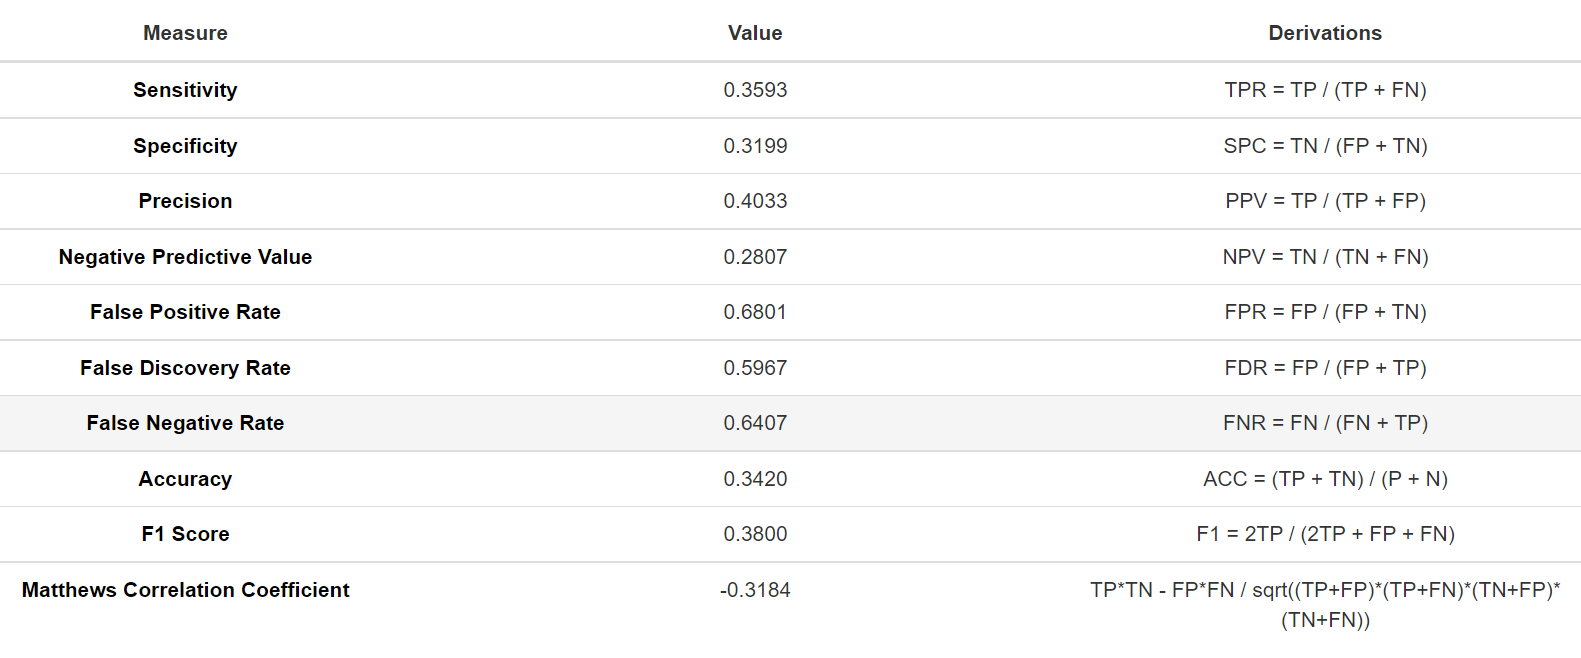

Agglomerative Clustering Analysis through Clustimage library

In [ ]:
!pip install clustimage

In [ ]:
from clustimage import Clustimage

In [ ]:
cl = Clustimage(method='pca', grayscale=True)

In [ ]:
Xda = cl.import_data(X1_np)

In [ ]:
Xfeat = cl.extract_feat(Xda)

In [ ]:
xycoord = cl.embedding(Xfeat)

In [ ]:
labels = cl.cluster(cluster='agglomerative',
                    evaluate='silhouette',
                    metric='euclidean',
                    linkage='ward',
                    min_clust=3,
                    max_clust=25,
                    cluster_space='high')

In [ ]:
# Return
results = cl.results

In [ ]:
# Results are stored as a dictionary:
cl.results.keys()

# 'feat'      : Extracted features.
# 'xycoord'   : The X and Y coordinates from tSNE embedding
# 'pathnames' : The path locations of the processed images
# 'filenames' : The filename of the image
# 'labels'    : The cluster labels

In [ ]:
# Silhouette plots
cl.clusteval.plot()
cl.clusteval.scatter(cl.results['xycoord'])

# PCA explained variance plot
cl.pca.plot()

# Dendrogram
cl.dendrogram()

# Plot unique image per cluster
cl.plot_unique(img_mean=False)

# Scatterplot
cl.scatter(zoom=3, img_mean=False)
cl.scatter(zoom=None, img_mean=False)

# Plot images per cluster or all clusters
cl.plot(cmap='binary', labels=[1,2])
cl.plot(cmap='binary')